# Segment Anything Model (SAM)

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import glob
import cv2
import tqdm
import os
from PIL import Image
import albumentations as A
from transformers import SamModel, SamProcessor
import requests
from transformers import pipeline

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.data import ConcatDataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setting up the GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Creating Dataset

In [3]:
class ImagesDataset(Dataset):

    def __init__(self, images_root_dir, masks_root_dir, tfImg, tfMsk, augmentation=None, min_size=256):
        self.images_path = images_root_dir
        self.masks_path = masks_root_dir
        self.tfImg = tfImg
        self.tfMsk = tfMsk
        self.augmentation = augmentation
        self.min_size = min_size
        
        self.images = sorted(images_root_dir)
        self.masks = sorted(masks_root_dir)
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = Image.open(img_name)
        mask = Image.open(mask_name).convert("L") 
        #mask = Image.open(mask_name)
        
        image = self.tfImg(image)
        mask = self.tfMsk(mask)
        

        if self.augmentation:
            image_np = np.array(image)
            mask_np = np.array(mask)
            transformed = self.augmentation(image=image_np, mask=mask_np)
            image = torch.from_numpy(np.copy(transformed['image'])).float()
            mask = torch.from_numpy(np.copy(transformed['mask'])).float()

        return image, mask

## Loading the Images and Masks

In [4]:
# modify the root path based on your environment
images_root_dir = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images'
masks_root_dir = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks'

### Clean dataset

**Remove duplicate and abnormal images and masks**

In [5]:
import imagehash

hashes = {}
to_remove = []

for img_name in os.listdir(images_root_dir):
    file = os.path.join(images_root_dir, img_name)
    mask_file = os.path.join(masks_root_dir, os.path.basename(file))
    img = Image.open(file)
    # Compute the hash value for the image
    h = imagehash.phash(img) 
    
    # Check if the hash value already exists in the dictionary
    if h in hashes:
        to_remove.append(file)
        to_remove.append(mask_file)
    else:
        hashes[h] = file
        min_size = 32
        n = cv2.imread(file, cv2.COLOR_BGR2RGB)
        m = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        # Check if the image has size > min_size and isn't entirely black or white 
        if not(min(n.shape[:2]) > min_size and ((m != 0).any() and (m != 255).any())):
            to_remove.append(file)
            to_remove.append(mask_file)

**Create a new list of filenames that excludes the duplicates and abnormal data**

In [6]:
new_images_list =[]
ratio = 1
for img_name in os.listdir(images_root_dir):
    if os.path.join(images_root_dir, img_name) not in to_remove:
        sample = np.random.uniform()
        if sample <= ratio:
            new_images_list.append(os.path.join(images_root_dir, img_name))
    
new_masks_list = [os.path.join(masks_root_dir, os.path.basename(file)) for file in new_images_list]
print(len(new_images_list), len(new_masks_list))

2698 2698


In [7]:
new_images_list_aug =[]
ratio = 0.5
for img_name in os.listdir(images_root_dir):
    if os.path.join(images_root_dir, img_name) not in to_remove:
        sample = np.random.uniform()
        if sample <= ratio:
            new_images_list_aug.append(os.path.join(images_root_dir, img_name))
    
new_masks_list_aug = [os.path.join(masks_root_dir, os.path.basename(file)) for file in new_images_list_aug]
print(len(new_images_list_aug), len(new_masks_list_aug))

1313 1313


### Building the Dataset

In [8]:
height = width = 256

In [9]:
tfImg = transforms.Compose([
    transforms.Resize((height, width)),  
    transforms.ToTensor(),  
])

tfMsk = transforms.Compose([
    transforms.Resize((height, width)),  
    transforms.ToTensor(),  
])

In [10]:
original_dataset = ImagesDataset(new_images_list, new_masks_list, tfImg=tfImg, tfMsk=tfMsk)

## Data Augmentation

In [11]:
augmentation_pipeline = A.Compose([
    #A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
],is_check_shapes=False)

In [12]:
augmentated_dataset = ImagesDataset(new_images_list_aug, new_masks_list_aug, tfImg=tfImg, tfMsk=tfMsk, augmentation=augmentation_pipeline)
dataset = ConcatDataset([original_dataset, augmentated_dataset])

### Show a sample of augmented images

In [ ]:
sample = np.random.randint(len(augmentated_dataset))
sample_image_aug, sample_mask_aug = augmentated_dataset[sample]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_image_aug.permute(1, 2, 0))
ax[0].set_title('Augmented Image')
ax[1].imshow(sample_mask_aug[0])
ax[1].set_title('Augmented Mask')
plt.show()


## Display a sample from Dataset

### water_body_1.jpg Image and Mask

Text(0.5, 1.0, 'MASK')

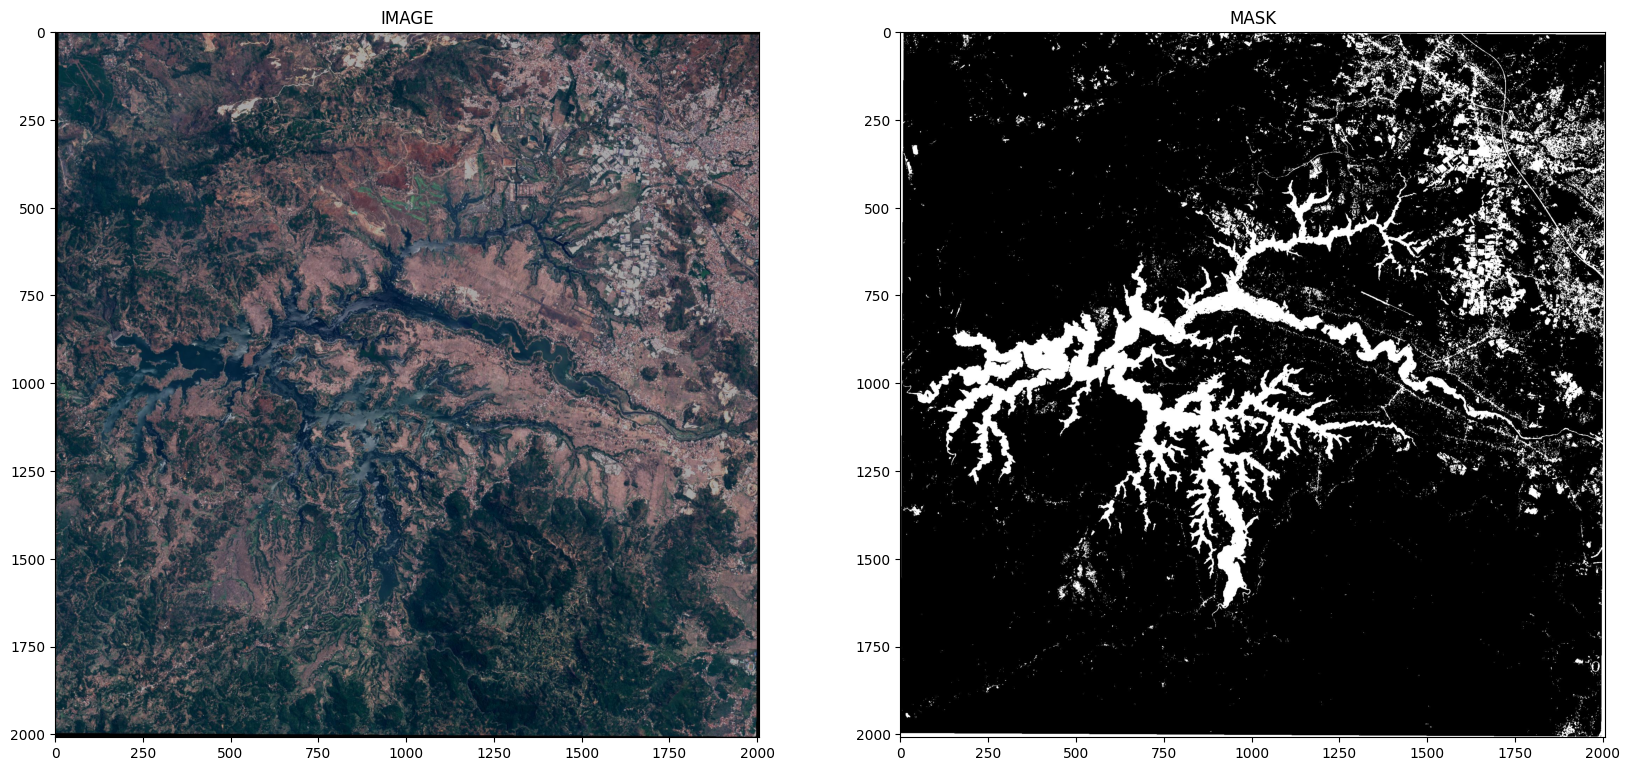

In [13]:
images_list = sorted(glob.glob("/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*.jpg"))
masks_list = sorted(glob.glob("/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*.jpg"))

f, axr = plt.subplots(1, 2, figsize=(20, 36)) 
img = Image.open(images_list[0])
mask = Image.open(masks_list[0]).convert('L')
axr[0].imshow(img)
axr[1].imshow(mask, cmap='gray')
axr[0].set_title("IMAGE")
axr[1].set_title("MASK")

(2007, 2009)
(2009, 2007, 3)


(-0.5, 2006.5, 2008.5, -0.5)

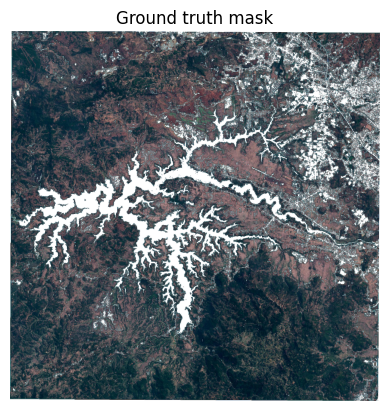

In [14]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()
print(img.size)
print(np.array(img).shape)
axes.imshow(np.array(img))
ground_truth_seg = np.array(mask)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

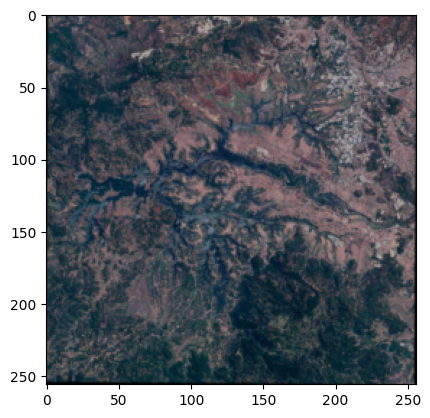

In [15]:
image, mask = dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.show()

### Resize images and masks

### Train-Test Split

In [16]:
test_ratio = 0.1
train_size = int((1 - test_ratio) * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [17]:
len(train_dataset)

3609

### Get bounding boxes from the ground truth masks 

In [18]:
def get_bounding_box(ground_truth_mask):
    # get bounding box from mask 
    y_indices, x_indices = np.where(ground_truth_mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [19]:
bbox = get_bounding_box(np.array(mask[0]))
bbox

[0, 0, 256, 256]

In [20]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        image = img
        ground_truth_mask = np.array(mask[0])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

## Importing the Model

**Model Details**
The SAM model is made up of 3 modules:
<br>**The VisionEncoder**: a VIT based image encoder. It computes the image embeddings using attention on patches of the image. Relative Positional Embedding is used.
<br>**The PromptEncoder**: generates embeddings for points and bounding boxes.
<br>**The MaskDecoder**: a two-ways transformer which performs cross attention between the image embedding and the point embeddings (->) and between the point embeddings and the image embeddings. The outputs are fed
<br>**The Neck**: predicts the output masks based on the contextualized masks produced by the MaskDecoder.


In [21]:
model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

### Building SamDataset so that train dataset is pre-processed by SamProcessor

In [22]:
Sam_train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
Sam_test_dataset = SAMDataset(dataset=test_dataset, processor=processor)

In [23]:
example = Sam_train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


### Creating the DataLoader

In [24]:
train_dataloader = DataLoader(Sam_train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(Sam_test_dataset, batch_size=2, shuffle=False)

### Usage
Prompted-Mask-Generation

In [25]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
input_points = [[[450, 600]]] # 2D localization of a window


In [26]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

### Automatic-Mask-Generation

In [27]:
generator =  pipeline("mask-generation", device = 0, points_per_batch = 256, model=model, image_processor=processor)
generator = pipeline(model="facebook/sam-vit-base", task="mask-generation", points_per_batch = 256)
image_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
outputs = generator(raw_image, points_per_batch = 256)

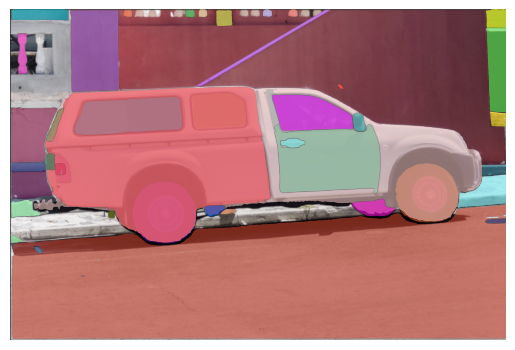

In [28]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
raw_image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
plt.imshow(np.array(raw_image))
ax = plt.gca()
for mask in outputs["masks"]:
    show_mask(mask, ax=ax, random_color=True)
plt.axis("off")
plt.show()

## Optimizer, Metrics and Loss Fucntion

### Intersection over Union (IoU) Score
IoU measures the ratio of the intersection of the predicted and ground truth masks to the union of these masks.It ranges from 0 to 1, where 0 indicates no overlap, and 1 indicates perfect overlap.
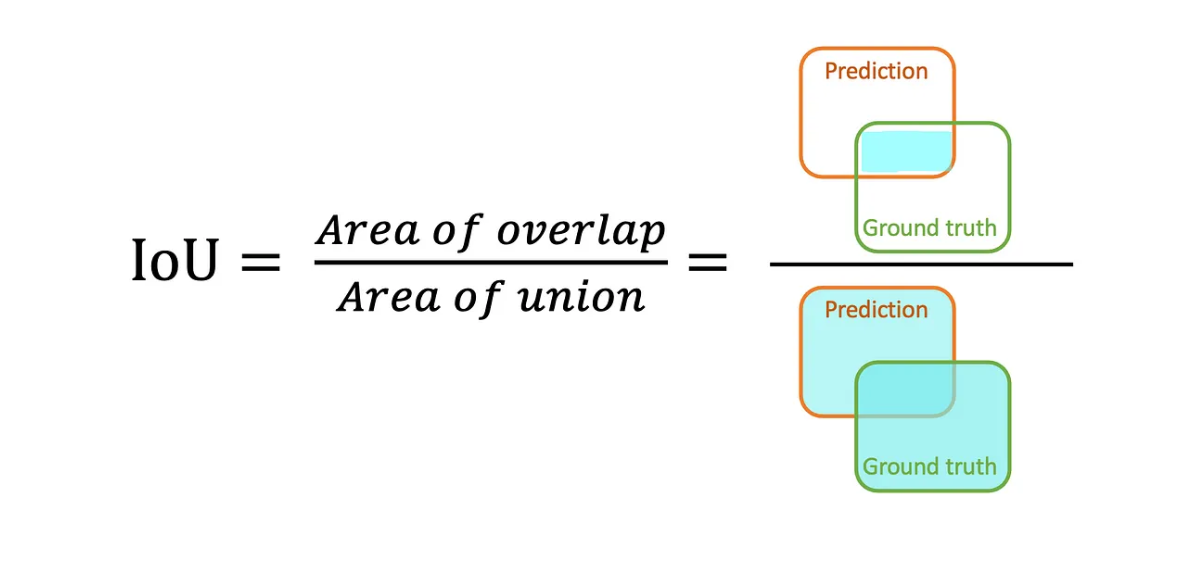

In [29]:
def calculate_iou(true_mask, pred_mask):
    intersection = np.sum(pred_mask*true_mask)
    union = np.sum(pred_mask) + np.sum(true_mask) - intersection
    iou = np.mean(intersection/union)
    return round(iou, 4)

### Dice Coefficient
The Dice Coefficient measures the similarity between the predicted and ground truth masks. In other words, it is calculated by 2*intersection divided by the total number of pixel in both images.
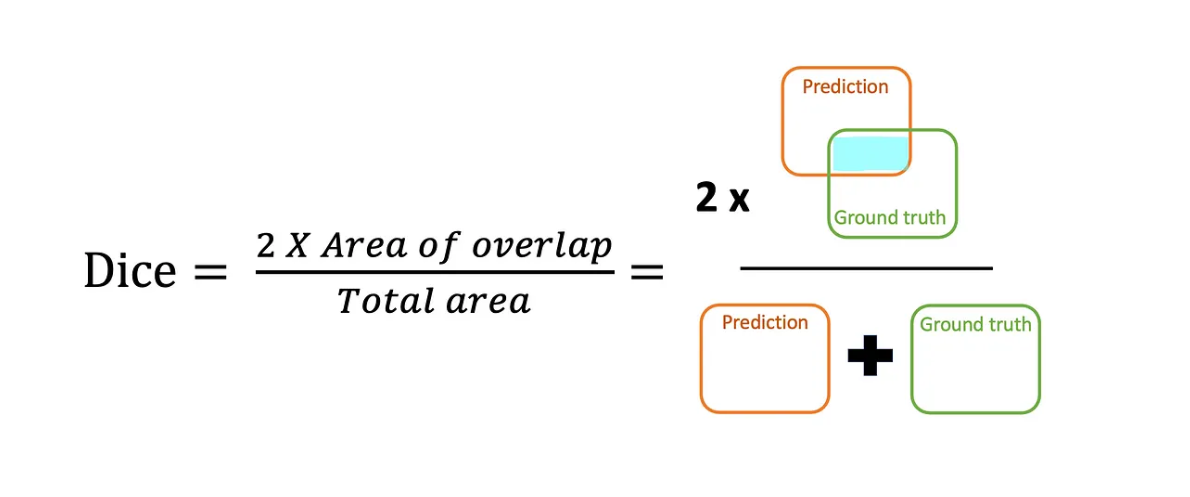

In [30]:
def calculate_dice_coefficient(true_mask, pred_mask):
    intersect = np.sum(pred_mask*true_mask)
    total_sum = np.sum(pred_mask) + np.sum(true_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 4) 

### Optimizer and Loss Function

In [31]:
!pip install -q monai

In [32]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
#loss_fn = torch.nn.MSELoss()#

## Fine-Tune

**Freeze Vision Encoder and Prompt Encoder**

In [33]:
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [34]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 8
train_losses = []
test_iou_scores = []
test_dice_coefficient = []

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1).to(device)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    mean_loss_train = mean(epoch_losses)
    train_losses.append(mean_loss_train)
    print(f'EPOCH: {epoch + 1}')
    print(f'Mean loss: {mean(epoch_losses)}')
    
    # Evaluation on the test dataset
    model.eval()  # Set the model to evaluation mode
    iou_scores = []
    dice_coeffs = []

    with torch.no_grad():
        for test_batch in tqdm(test_dataloader):  # Assuming test_dataloader is your DataLoader for the test dataset
            # Forward pass on the test data
            test_outputs = model(pixel_values=test_batch["pixel_values"].to(device),
                                input_boxes=test_batch["input_boxes"].to(device),
                                multimask_output=False)

            # Get predictions and ground truth masks for test data
            predicted_masks_test = test_outputs.pred_masks.squeeze(1).to(device)
            ground_truth_masks_test = test_batch["ground_truth_mask"].float().to(device)

            # Apply post-processing if needed (e.g., binarization)
            # binary_mask_test = normalize(threshold(predicted_masks_test, 0.0, 0))
            # Normalize the output_mask to be in the range [0, 1]
            binary_mask_test = torch.sigmoid(predicted_masks_test)

            # Ensure both tensors have the same shape
            output_mask_test = binary_mask_test.view(binary_mask_test.size(0), binary_mask_test.size(2), binary_mask_test.size(3))
            ground_truth_mask_test = ground_truth_masks_test.view(ground_truth_masks_test.size(0), ground_truth_masks_test.size(1), ground_truth_masks_test.size(2))

            # Calculate IOU for the test data
            iou_score_test = calculate_iou(ground_truth_mask_test.cpu().numpy(), output_mask_test.cpu().numpy())
            iou_scores.append(iou_score_test)
            
            # Calculate DICE for the test data
            dice_coeff_test = calculate_dice_coefficient(ground_truth_mask_test.cpu().numpy(), output_mask_test.cpu().numpy())
            dice_coeffs.append(dice_coeff_test)

    # Print or use the mean IOU score for evaluation after each epoch
    mean_iou_test = mean(iou_scores)
    test_iou_scores.append(mean_iou_test)
    mean_dice_test = mean(dice_coeffs)
    test_dice_coefficient.append(mean_dice_test)
    
    print(f'IOU on the test dataset after epoch {epoch + 1}: {mean_iou_test}')
    print(f'Dice on the test dataset after epoch {epoch + 1}: {mean_dice_test}')

    # Set the model back to training mode
    model.train()

100%|██████████| 1805/1805 [33:09<00:00,  1.10s/it]


EPOCH: 1
Mean loss: 1.022130759171832


100%|██████████| 201/201 [03:33<00:00,  1.06s/it]


IOU on the test dataset after epoch 1: 0.28588008880615234
Dice on the test dataset after epoch 1: 0.43525273631840794


100%|██████████| 1805/1805 [32:35<00:00,  1.08s/it]


EPOCH: 2
Mean loss: 0.9813401442815722


100%|██████████| 201/201 [03:31<00:00,  1.05s/it]


IOU on the test dataset after epoch 2: 0.2675487697124481
Dice on the test dataset after epoch 2: 0.4145597014925373


100%|██████████| 1805/1805 [32:38<00:00,  1.09s/it]


EPOCH: 3
Mean loss: 0.9728543235819755


100%|██████████| 201/201 [03:31<00:00,  1.05s/it]


IOU on the test dataset after epoch 3: 0.26589998602867126
Dice on the test dataset after epoch 3: 0.4131039800995025


100%|██████████| 1805/1805 [32:40<00:00,  1.09s/it]


EPOCH: 4
Mean loss: 0.9668633046407779


100%|██████████| 201/201 [03:30<00:00,  1.05s/it]


IOU on the test dataset after epoch 4: 0.2857059836387634
Dice on the test dataset after epoch 4: 0.4358686567164179


100%|██████████| 1805/1805 [32:32<00:00,  1.08s/it]


EPOCH: 5
Mean loss: 0.9637036852063895


100%|██████████| 201/201 [03:29<00:00,  1.04s/it]


IOU on the test dataset after epoch 5: 0.2855965197086334
Dice on the test dataset after epoch 5: 0.4356318407960199


100%|██████████| 1805/1805 [32:23<00:00,  1.08s/it]


EPOCH: 6
Mean loss: 0.9566322626004259


100%|██████████| 201/201 [03:30<00:00,  1.05s/it]


IOU on the test dataset after epoch 6: 0.2943328320980072
Dice on the test dataset after epoch 6: 0.44635671641791047


100%|██████████| 1805/1805 [32:31<00:00,  1.08s/it]


EPOCH: 7
Mean loss: 0.956361167302092


100%|██████████| 201/201 [03:30<00:00,  1.05s/it]


IOU on the test dataset after epoch 7: 0.2507562041282654
Dice on the test dataset after epoch 7: 0.39615572139303484


100%|██████████| 1805/1805 [32:31<00:00,  1.08s/it]


EPOCH: 8
Mean loss: 0.9535324102128312


100%|██████████| 201/201 [03:31<00:00,  1.05s/it]

IOU on the test dataset after epoch 8: 0.26650696992874146
Dice on the test dataset after epoch 8: 0.4148034825870647


## Evaluation 

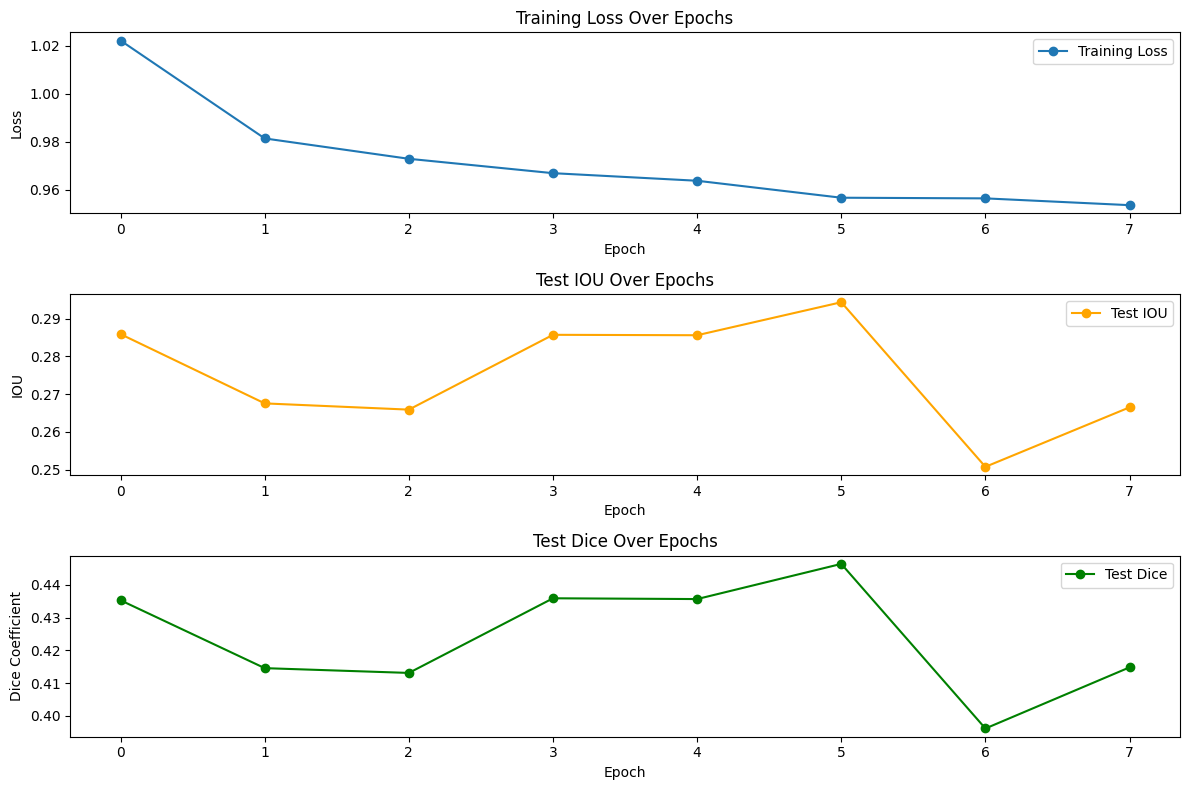

In [35]:
plt.figure(figsize=(12, 8))

# Plot Training Loss
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Test IOU Scores
plt.subplot(3, 1, 2)
plt.plot(test_iou_scores, label='Test IOU', marker='o', color='orange')
plt.title('Test IOU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()

# Plot Test Dice Coefficient
plt.subplot(3, 1, 3)
plt.plot(test_dice_coefficient, label='Test Dice', marker='o', color='green')
plt.title('Test Dice Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()


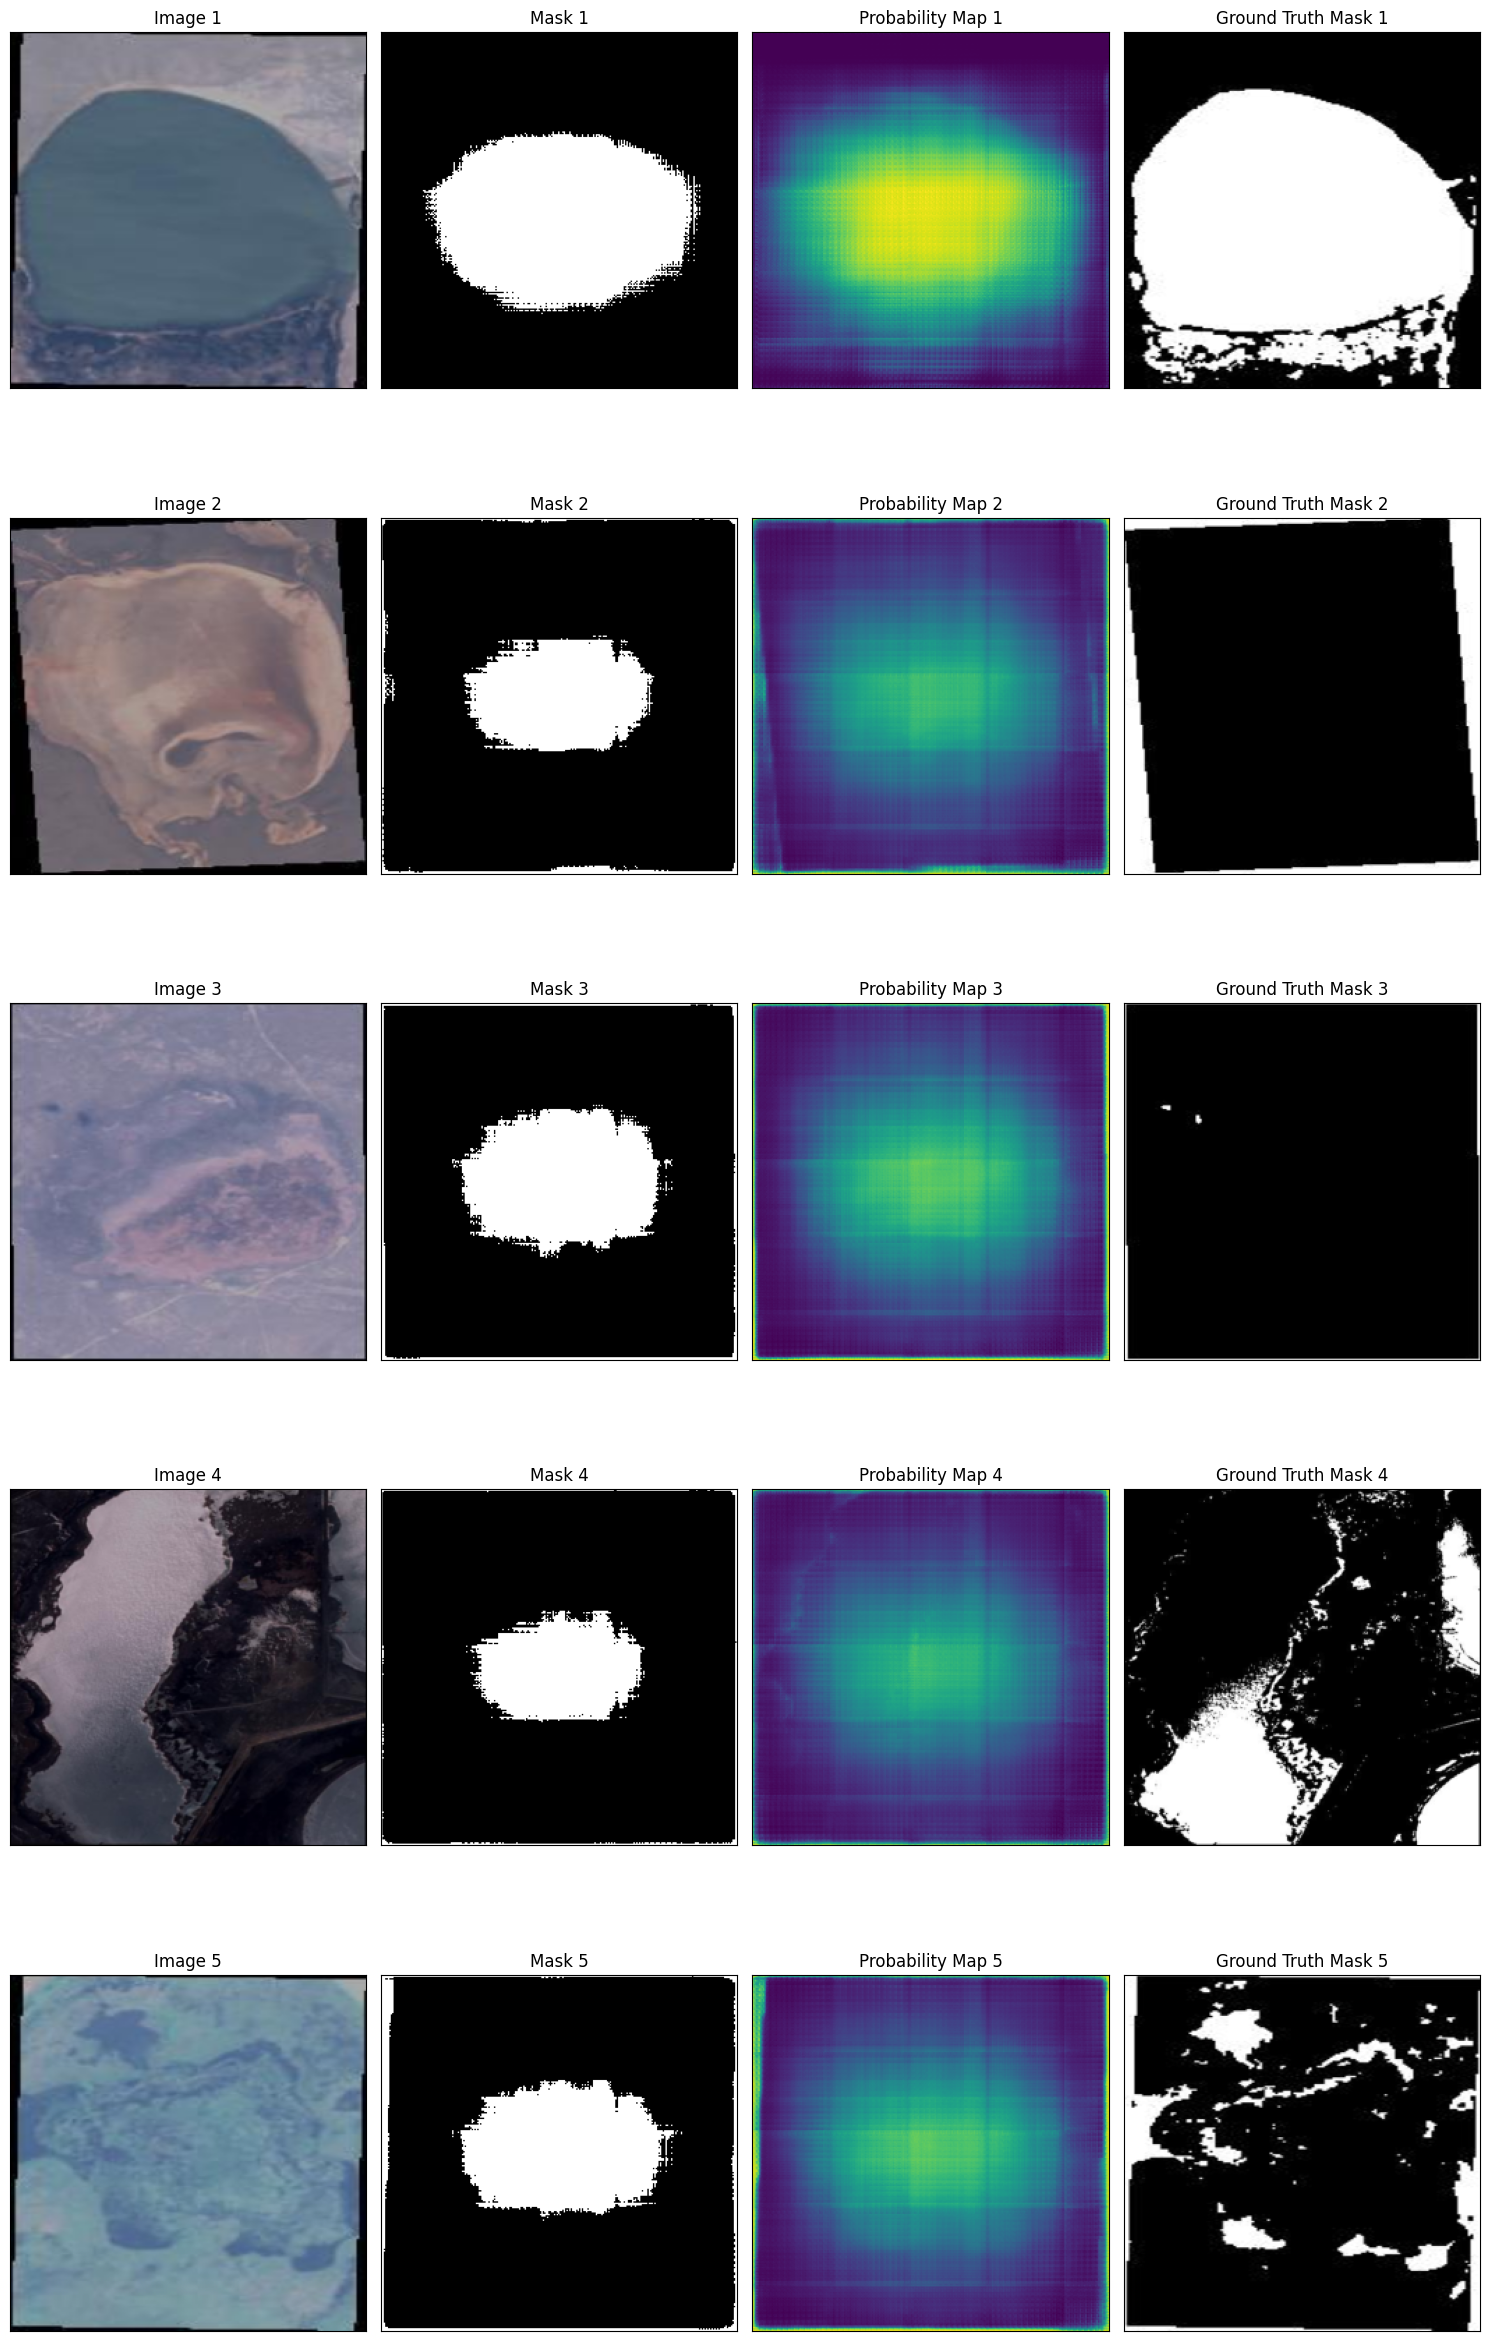

In [36]:
# Set the number of test examples to display
num_test_examples = 5

fig, axes = plt.subplots(num_test_examples, 4, figsize=(15, 5*num_test_examples))

for i in range(num_test_examples):
    idx = random.randint(0, len(test_dataset)-1)

    img, mask = dataset[idx]

    ground_truth_mask = np.array(mask[0])
    prompt = get_bounding_box(ground_truth_mask)

    inputs = processor(img, input_boxes=[[prompt]], return_tensors="pt")

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    # Plot the images
    axes[i, 0].imshow(img.permute(1, 2, 0).numpy(), cmap='gray')
    axes[i, 0].set_title(f"Image {i+1}")

    axes[i, 1].imshow(medsam_seg, cmap='gray')
    axes[i, 1].set_title(f"Mask {i+1}")

    axes[i, 2].imshow(medsam_seg_prob)
    axes[i, 2].set_title(f"Probability Map {i+1}")

    # Plot the ground truth mask
    axes[i, 3].imshow(ground_truth_mask, cmap='gray')
    axes[i, 3].set_title(f"Ground Truth Mask {i+1}")

    for ax in axes[i]:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()


## Citation

@article{kirillov2023segany,
  title={Segment Anything},
  author={Kirillov, Alexander and Mintun, Eric and Ravi, Nikhila and Mao, Hanzi and Rolland, Chloe and Gustafson, Laura and Xiao, Tete and Whitehead, Spencer and Berg, Alexander C. and Lo, Wan-Yen and Doll{\'a}r, Piotr and Girshick, Ross},
  journal={arXiv:2304.02643},
  year={2023}
}


@Article{info11020125,
    AUTHOR = {Buslaev, Alexander and Iglovikov, Vladimir I. and Khvedchenya, Eugene and Parinov, Alex and Druzhinin, Mikhail and Kalinin, Alexandr A.},
    TITLE = {Albumentations: Fast and Flexible Image Augmentations},
    JOURNAL = {Information},
    VOLUME = {11},
    YEAR = {2020},
    NUMBER = {2},
    ARTICLE-NUMBER = {125},
    URL = {https://www.mdpi.com/2078-2489/11/2/125},
    ISSN = {2078-2489},
    DOI = {10.3390/info11020125}
}